In [39]:
import datetime
import os
import copy
import sys
import csv
import random
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from scipy.stats import pearsonr # 科学技術計算ライブラリ
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

import read_dataset
import log
from model import model



In [7]:
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True


In [53]:
test_path = "./log/BEST_conditional_0_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid0"

test_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor()#,
        #transforms.Normalize((0.5,), (0.5,))
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_df = pd.read_csv("./female_factor_score.csv")

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
net = model(attribute_num=2,conditional_flg=1, bottle=16)
net.load_state_dict(torch.load(os.path.join(test_path,"model_dict.pth")))
net = net.to(device)
attribute = torch.Tensor([1,0]) # male:[1,0]. female:[0,1]
attribute = torch.reshape(attribute, (1, 2))

##  画像読み込み(1枚)
img_path = "/dataset/dataset/taki/data/bento/bento_dataset1000/tomoko (26).jpg"
img = Image.open(img_path)
img = test_transform(img)
img = torch.Tensor(img)
img = torch.reshape(img, (1, 3,640,640))

with torch.no_grad():  # 勾配の消失
    img = img.to(device)
    output = net(img,attribute.to(device))

pred = output.to('cpu').detach().numpy().copy()

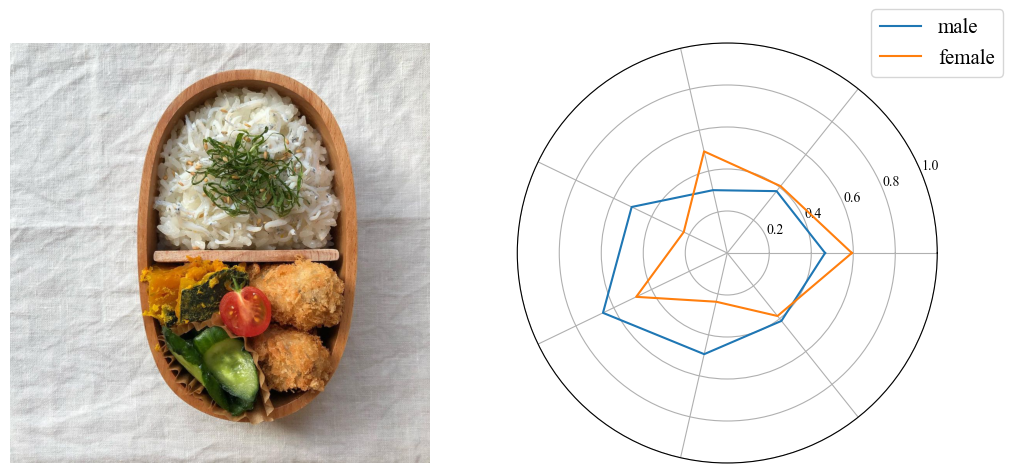

In [76]:
col = ["","","","","","",""]

df = pd.read_csv("./male_female_factor_score.csv")

img = Image.open(img_path)

img_val = "tomoko (26).jpg"
img_idx = df.index[df["path"] == img_val]

# 多角形を閉じるためにデータの最後に最初の値を追加する。
output_values = np.append(pred[0], pred[0][0])
# male
#output_values = np.append(df.loc[img_idx[0]]["factor1":"factor7"], df.loc[img_idx[0]]["factor1":"factor7"][0])
# female
score_values  = np.append(df.loc[img_idx[0]]["factor1":"factor7"], df.loc[img_idx[0]]["factor1":"factor7"][0])

# プロットする角度を生成する。
angles = np.linspace(0, 2 * np.pi, len(col) + 1 , endpoint=True)

plt.rcParams['font.family']='Times New Roman'

fig = plt.figure(figsize=(12, 12))

# libのmatplotのファイルのデフォルトフォントを変えた
#plt.rcParams['font.family'] = 'IPAexGothic'
#print(plt.rcParams["font.family"])
#plt.rcParams["font.family"] = 'sans-serif'   # 使用するフォント
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2, polar=True)

#img_path = data_dir +  img_name[index_list[i]]
#ax0.imshow(mpimg.imread(img_path))
ax0.axis("off")
ax0.imshow(img)
#ax0.set_title(img_path[index_list[i]], pad=20)


# 極座標でaxを作成。
# レーダーチャートの線を引く
ax1.plot(angles, output_values, label="male")
ax1.plot(angles, score_values, label="female")

# 項目ラベルの表示
ax1.set_thetagrids(angles[:-1] * 180 / np.pi, col,fontname="Times New Roman", fontsize=15)
ax1.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0]) # メモリ線

ax1.legend(bbox_to_anchor=(1, 1), loc='center', borderaxespad=0,fontsize=15)
tmp = img_val.split()[1].split(".")[0]
plt.savefig(f"./img_for_paper/ground truth/{img_val.split()[0]}{tmp}.svg")#, transparent=True)
#plt.title(img_val)
#ax1.set_title(f"L1loss_mean:{np.round(L1_loss.mean(), 3)}" , pad=20)
plt.show()
#plt.savefig(f"./img_for_paper/{img_val}")#, transparent=True)

#img_path = save_path +  f"/closs_valid{cv_num}_{i}.png"
#img_path = save_path +  f"/closs_valid{cv_num}_index{i}_mae{large_list2[idx]}.svg"






plt.clf() # 図全体をクリア
plt.cla() # 軸をクリア
plt.close('all') # closes all the figure windows

In [74]:
pred[0][0]

0.4657232

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
net = model(attribute_num=2,conditional_flg=1, bottle=16)
net.load_state_dict(torch.load(os.path.join(test_path,"model_dict.pth")))
net = net.to(device)
attribute = torch.Tensor([0,1])
attribute = torch.reshape(attribute, (1, 2))

with torch.no_grad():  # 勾配の消失
    img = img.to(device)
    output = net(img,attribute.to(device))

output

tensor([[0.6012, 0.4463, 0.5614, 0.4446, 0.5602, 0.5132, 0.4611]],
       device='cuda:0')

In [18]:
os.path.join(test_path,"model_dict.pth")

'./log/BEST_conditional_0_bottle16_optimAdam_batch32_w,h640_lr0.0001_wDecay0.0001_seed0_rotation360_1014/closs_valid1/model_dict.pth'

In [4]:
test_index_df = pd.read_csv(os.path.join(test_path, "testdata_index.csv"))
test_index_df

,Unnamed: 0,path
0,59,hitorigohan (195).jpg
1,298,m_bookcook (93).jpg
2,112,nagae_bento (82).jpg
3,322,onaka__suita (118).jpg
4,15,aknms (127).jpg
...,...,...
195,347,sora (67).jpg
196,267,makiwappa (130).jpg
197,374,uco (99).jpg
198,285,miiko (63).jpg


In [5]:
attribute_df = pd.read_csv(os.path.join(test_path, "attribute_df.csv"))
attribute_df

,Unnamed: 0,0,1
0,0,1.0,0.0
1,1,0.0,1.0
2,2,1.0,0.0
3,3,0.0,1.0
4,4,1.0,0.0
...,...,...,...
195,195,0.0,1.0
196,196,0.0,1.0
197,197,0.0,1.0
198,198,0.0,1.0
